In [593]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split
from pathlib import Path
import requests

## device agnostic code

In [594]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [595]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, accuracy_fn, plot_decision_boundary


helper_functions.py already exists


## create and visualize data

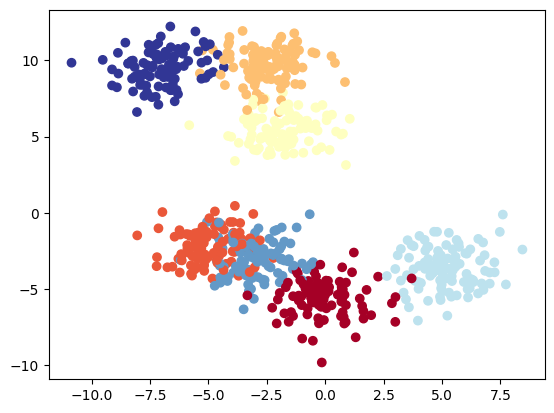

In [596]:
X_blob, y_blob = make_blobs(
                            n_samples=700,
                            n_features=2,
                            centers=7,
                            cluster_std=1.15,
                            center_box=(-10.0, 10.0),
                            shuffle=True,
                            random_state=50,
                            return_centers=False
                            )
plt.scatter(
          x=X_blob[:, 0],
          y=X_blob[:, 1],
          c=y_blob,
          cmap=plt.cm.RdYlBu
          );

## check data type

In [597]:
type(X_blob)

numpy.ndarray

## convert from nd.array to torch.tensor

In [598]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [599]:
type(X_blob)

torch.Tensor

## create train/test split

In [600]:
X_train, X_test, y_train, y_test = train_test_split(
                  X_blob,
                  y_blob,
                  train_size=0.8,
                  random_state=50
                  )

## create model for data analysis

In [601]:
class BlobModelV1(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.linear_layer = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer(x)

model_1 = BlobModelV1(2, 7).to(device)
model_1_str = str(model_1)
clean_model_1_str = model_1_str.replace("(", " ").replace(")", " ")

## define loss function and optimizer

In [602]:
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.015)
optimizer_class_name = optimizer_1.__class__.__name__
learning_rate = optimizer_1.param_groups[0]["lr"]

## write training and test loop

In [603]:
torch.manual_seed(50)
torch.cuda.manual_seed(50)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

epochs = 1050

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train)

  y_pred = torch.argmax(y_logits, dim=1)
  loss_1 = loss_fn_1(y_logits, y_train)

  acc_1 = accuracy_fn(y_train, y_pred)
  optimizer_1.zero_grad()
  loss_1.backward()
  optimizer_1.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test)

    test_pred = torch.argmax(test_logits, dim=1)
    test_loss_1 = loss_fn_1(test_logits, y_test)

    test_acc_1 = accuracy_fn(y_test, test_pred)

    if epoch % 50 == 0:
      epochs_count.append(epoch)
      loss_values.append(loss_1)
      acc_values.append(acc_1)
      test_loss_values.append(test_loss_1)
      test_acc_values.append(test_acc_1)
      print(f"Epoch: {epoch} | Loss: {loss_1:.5f} | Acc: {acc_1:.2f} | Test Loss: {test_loss_1:.5f} | Test Acc: {test_acc_1:.2f}")

Epoch: 0 | Loss: 3.50044 | Acc: 20.71 | Test Loss: 3.13423 | Test Acc: 22.86
Epoch: 50 | Loss: 1.02294 | Acc: 64.46 | Test Loss: 0.99546 | Test Acc: 65.71
Epoch: 100 | Loss: 0.75842 | Acc: 78.39 | Test Loss: 0.76683 | Test Acc: 74.29
Epoch: 150 | Loss: 0.66849 | Acc: 79.64 | Test Loss: 0.68571 | Test Acc: 77.14
Epoch: 200 | Loss: 0.62008 | Acc: 80.18 | Test Loss: 0.64112 | Test Acc: 79.29
Epoch: 250 | Loss: 0.58822 | Acc: 81.43 | Test Loss: 0.61158 | Test Acc: 81.43
Epoch: 300 | Loss: 0.56482 | Acc: 81.96 | Test Loss: 0.58985 | Test Acc: 82.14
Epoch: 350 | Loss: 0.54644 | Acc: 83.04 | Test Loss: 0.57281 | Test Acc: 82.86
Epoch: 400 | Loss: 0.53136 | Acc: 83.93 | Test Loss: 0.55886 | Test Acc: 83.57
Epoch: 450 | Loss: 0.51859 | Acc: 84.29 | Test Loss: 0.54708 | Test Acc: 84.29
Epoch: 500 | Loss: 0.50752 | Acc: 85.00 | Test Loss: 0.53691 | Test Acc: 85.00
Epoch: 550 | Loss: 0.49776 | Acc: 85.18 | Test Loss: 0.52797 | Test Acc: 85.71
Epoch: 600 | Loss: 0.48902 | Acc: 85.36 | Test Loss: 0.

## plot training | test | accuracy over epochs

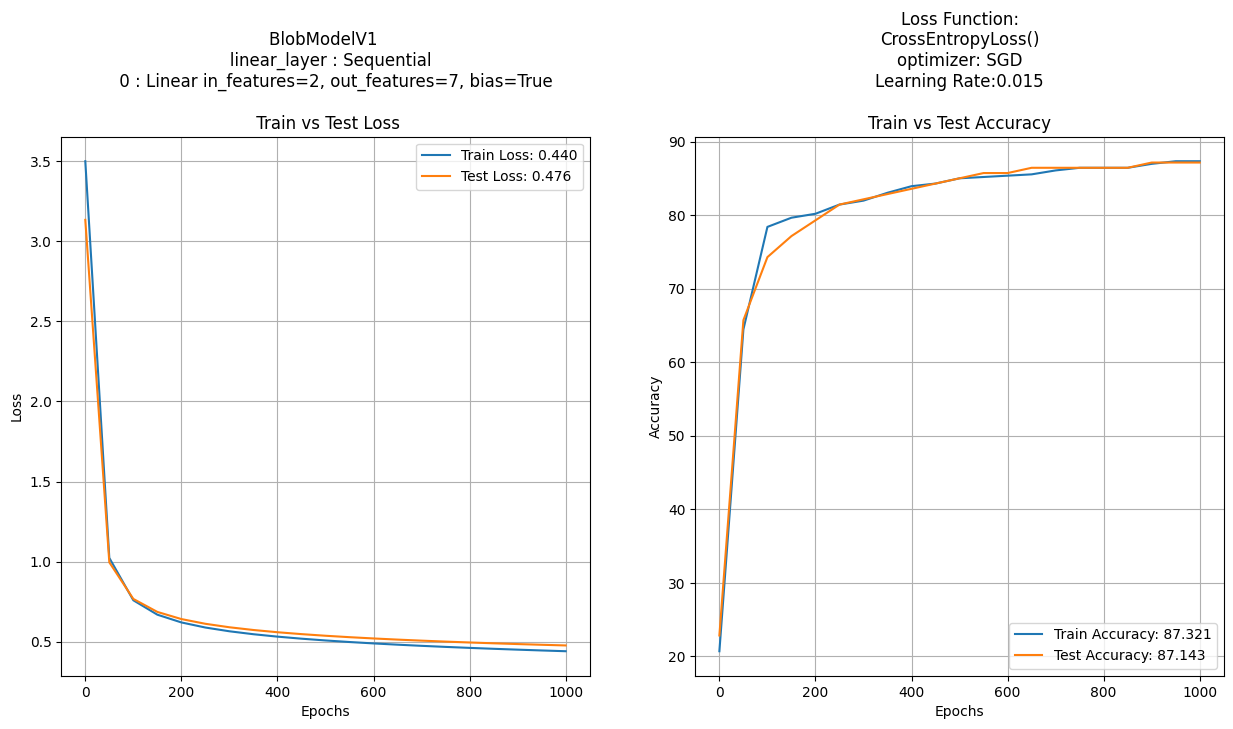

In [604]:
final_loss = loss_values[-1]
final_test_loss = test_loss_values[-1]
final_acc = acc_values[-1]
final_test_acc = test_acc_values[-1]

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(epochs_count, np.array(torch.tensor(loss_values).numpy()), label=f"Train Loss: {final_loss:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_loss_values).numpy()), label=f"Test Loss: {final_test_loss:.3f}")
plt.title(f"\n{clean_model_1_str}Train vs Test Loss")
plt.xlabel(f"Epochs")
plt.ylabel("Loss")
plt.legend();
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(epochs_count, np.array(torch.tensor(acc_values).numpy()), label=f"Train Accuracy: {final_acc:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_acc_values).numpy()), label=f"Test Accuracy: {final_test_acc:.3f}")
plt.title(f"Loss Function:\n{loss_fn_1}\noptimizer: {optimizer_class_name}\nLearning Rate:{learning_rate}\n\nTrain vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();


## plot result 

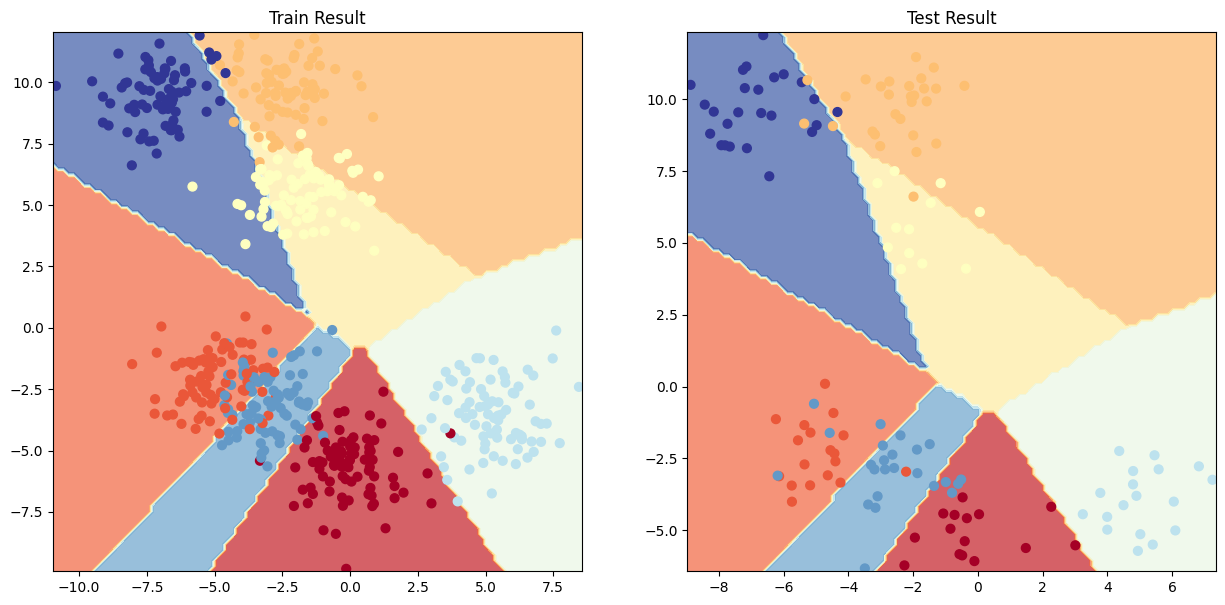

In [605]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Train Result")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test Result")
plot_decision_boundary(model_1, X_test, y_test)

In [606]:
class BlobModelV2(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=32),
            nn.Linear(in_features=32, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model_2 = BlobModelV2(2, 7).to(device)

def formate_model_info(model_n):
    model_str = str(model_n)
    cleaned_model_str = model_str.replace("(", " ").replace(")", " ")
    return cleaned_model_str
model_2_info = formate_model_info(model_2)

In [607]:
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

def format_optimizer_info(optimizer_n):
    optimizer_name = optimizer_n.__class__.__name__
    learning_rate = optimizer_n.param_groups[0]["lr"]
    return {"name": optimizer_name, "rate": learning_rate}
optim_2_info = format_optimizer_info(optimizer_2)
print(optim_2_info)

{'name': 'SGD', 'rate': 0.01}


In [608]:
def train_steps(model, loss_fn, optimizer, accuracy_fn, X_train, y_train):
    model.train()
    y_logits = model(X_train)
    loss = loss_fn(y_logits, y_train)
    y_pred = torch.argmax(y_logits, dim=1)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), acc
    

def test_steps(model, loss_fn, accuracy_fn, X_test, y_test):
    model.eval()
    with torch.inference_mode():
      test_logits = model(X_test)
      test_loss = loss_fn(test_logits, y_test)
      test_pred = torch.argmax(test_logits, dim=1)
      test_acc = accuracy_fn(y_test, test_pred)

    return test_loss.item(), test_acc

In [609]:
def train_loop(model, loss_fn, optimizer, accuracy_fn, 
               X_train, X_test, y_train, y_test, 
               epochs, print_freq, device=None):
    
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    loss_values = []
    acc_values = []
    test_loss_values = []
    test_acc_values = []

    for epoch in range(epochs):
        loss, acc = train_steps(model, loss_fn, optimizer, accuracy_fn,
                                X_train, y_train)
        test_loss, test_acc = test_steps(model, loss_fn, accuracy_fn, 
                                         X_test, y_test)
        
        if epoch % print_freq == 0:
            loss_values.append(loss)
            test_loss_values.append(test_loss)
            acc_values.append(acc)
            test_acc_values.append(test_acc)
            print(f"Epoch: {epoch} | Loss: {loss:.3f} | Acc: {acc:.3f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")

    
    return epochs_count, loss_values, acc_values, test_loss_values, test_acc_values

In [610]:
epochs_count_2, loss_values_2, acc_values_2, test_loss_values_2, test_acc_values_2 = train_loop(model_2, loss_fn_2, optimizer_2, accuracy_fn,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test,
                             device=device,
                             epochs=1050,
                             print_freq=50)


Epoch: 0 | Loss: 3.728 | Acc: 0.714 | Test Loss: 2.805 | Test Acc: 12.857
Epoch: 50 | Loss: 0.697 | Acc: 72.857 | Test Loss: 0.711 | Test Acc: 75.000
Epoch: 100 | Loss: 0.587 | Acc: 76.786 | Test Loss: 0.608 | Test Acc: 80.000
Epoch: 150 | Loss: 0.532 | Acc: 81.250 | Test Loss: 0.557 | Test Acc: 83.571
Epoch: 200 | Loss: 0.496 | Acc: 82.857 | Test Loss: 0.525 | Test Acc: 84.286
Epoch: 250 | Loss: 0.469 | Acc: 82.857 | Test Loss: 0.502 | Test Acc: 85.714
Epoch: 300 | Loss: 0.448 | Acc: 84.107 | Test Loss: 0.483 | Test Acc: 85.714
Epoch: 350 | Loss: 0.430 | Acc: 85.000 | Test Loss: 0.468 | Test Acc: 86.429
Epoch: 400 | Loss: 0.414 | Acc: 86.250 | Test Loss: 0.455 | Test Acc: 87.857
Epoch: 450 | Loss: 0.400 | Acc: 87.679 | Test Loss: 0.444 | Test Acc: 87.857
Epoch: 500 | Loss: 0.388 | Acc: 88.214 | Test Loss: 0.434 | Test Acc: 87.143
Epoch: 550 | Loss: 0.377 | Acc: 88.571 | Test Loss: 0.425 | Test Acc: 87.857
Epoch: 600 | Loss: 0.367 | Acc: 89.286 | Test Loss: 0.417 | Test Acc: 87.857
Epo

None


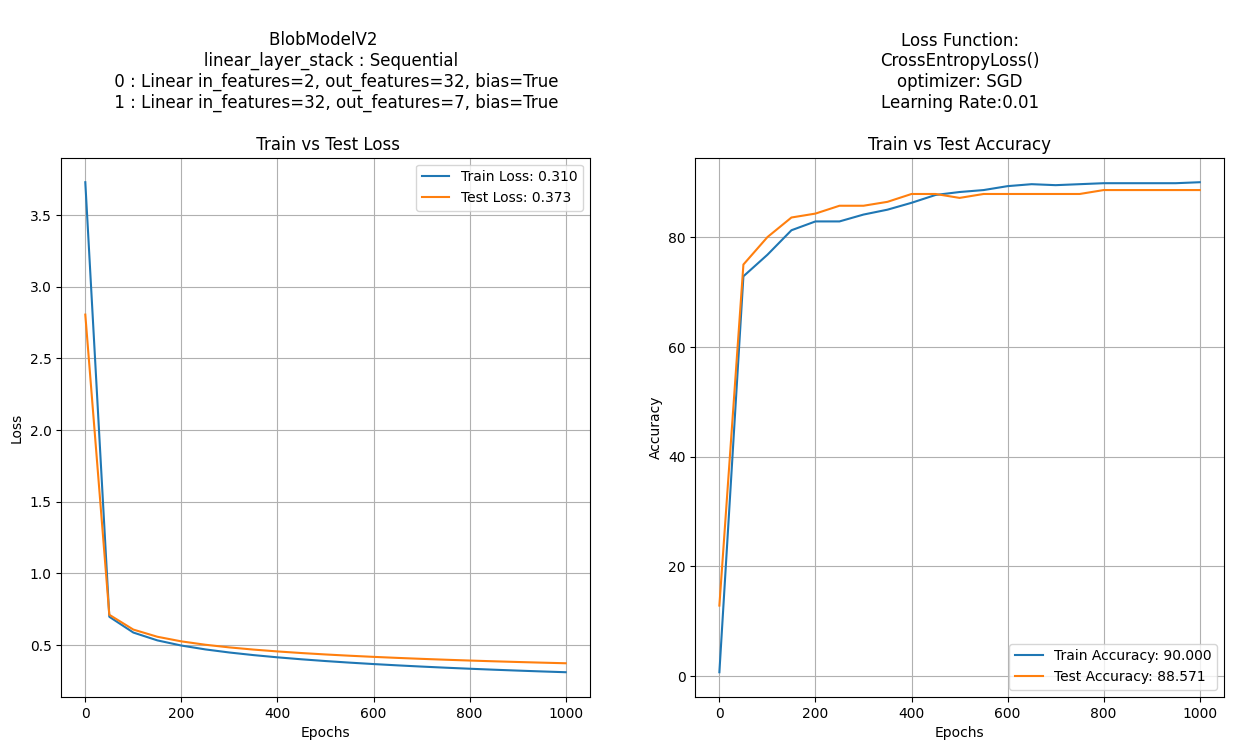

In [611]:
def plot_loss_accuracy(all_epochs, all_losses, all_test_losses, all_accs, all_test_accs, model_info, loss_func, optim, learn):

    final_loss = all_losses[-1]
    final_test_loss = all_test_losses[-1]
    final_acc = all_accs[-1]
    final_test_acc = all_test_accs[-1]

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.plot(epochs_count, np.array(torch.tensor(all_losses).numpy()), label=f"Train Loss: {final_loss:.3f}")
    plt.plot(epochs_count, np.array(torch.tensor(all_test_losses).numpy()), label=f"Test Loss: {final_test_loss:.3f}")
    plt.title(f"\n{model_info}Train vs Test Loss")
    plt.xlabel(f"Epochs")
    plt.ylabel("Loss")
    plt.legend();
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.plot(all_epochs, np.array(torch.tensor(all_accs).numpy()), label=f"Train Accuracy: {final_acc:.3f}")
    plt.plot(all_epochs, np.array(torch.tensor(all_test_accs).numpy()), label=f"Test Accuracy: {final_test_acc:.3f}")
    plt.title(f"Loss Function:\n{loss_func}\noptimizer: {optim}\nLearning Rate:{learn}\n\nTrain vs Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend();
print(plot_loss_accuracy(epochs_count_2, loss_values_2, test_loss_values_2, acc_values_2, test_acc_values_2, model_2_info, loss_fn_2, optim_2_info["name"], optim_2_info["rate"]))

None


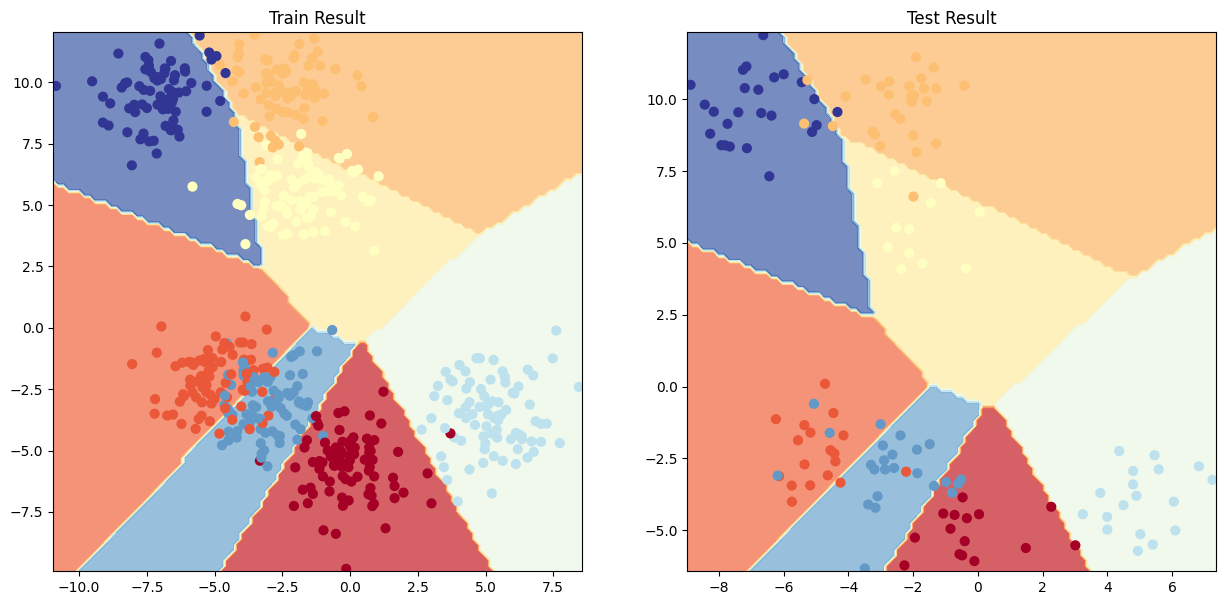

In [612]:
def plot_result(model):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.title("Train Result")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test Result")
    plot_decision_boundary(model, X_test, y_test)
print(plot_result(model_2))